<a href="https://colab.research.google.com/github/tousinritsu/PPL_lesson/blob/main/NumPyro_002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ベルヌーイ分布の学習・予測

In [1]:
!pip install -q jax funsor numpyro arviz causalgraphicalmodels daft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.9/174.9 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.6/72.6 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [8]:
from jax import jit
import jax.numpy as jnp
from jax import random
import numpy as np

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro import sample, plate, handlers
import funsor

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

plt.style.use("seaborn")

# 乱数シード固定
rng_key = random.PRNGKey(0)


次の構造を仮定する

【確率モデル】<br>
$x∼Bern(x|μ)$<br>
$x\in\{0,1\}$<br>
$p(x|μ)=Bern(x|μ)$

【事前分布】<br>
$μ∈(0,1)$,<br>
$p(μ|a,b)=Beta(μ|a,b)$

In [9]:
# modelを定義する
def model(X_obs = None):
  """
  X_obs :観測値
  """
  a = 2
  b = 2
  # numpyro.sampleとdist.sampleは異なるものであることに注意
  mu = numpyro.sample('mu', dist.Beta(a,b))
  x = numpyro.sample('x',dist.Bernoulli(mu),obs = X_obs)

  return x



## 観測値を使用しない場合
a,b定数として、そもそも観測値がないとどうなるか

In [32]:
# Run MCMC
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key=random.PRNGKey(0))

# print MCMC summary（推定パラメータの基本統計量）
mcmc.print_summary()

<ipython-input-32-192b16f841f2>:4: FutureWarning: Some algorithms will automatically enumerate the discrete latent site x of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  mcmc.run(rng_key=random.PRNGKey(0))
sample: 100%|██████████| 3000/3000 [00:04<00:00, 745.33it/s, 3 steps of size 9.33e-01. acc. prob=0.94] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.51      0.23      0.51      0.13      0.87    782.79      1.01

Number of divergences: 0


[0.8667454  0.569361   0.44099575 ... 0.66076124 0.38886777 0.84807914]


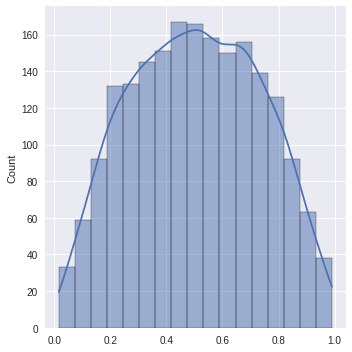

In [33]:
# mcmcでの推定パラメータを取得「
mcmc_samples = mcmc.get_samples()
print(mcmc_samples["mu"])
# muをプロット
sns.displot(
    mcmc_samples["mu"],
    kde = True
)

結果、$μ=0.51$と推定されている

## 観測値を使用しない場合
μ=0.8としてみる

In [29]:
# 予測対象のベルヌーイ分布
true_mu = 0.8
bern = dist.Bernoulli(true_mu)
obs = bern.sample(
    rng_key,
    sample_shape = (100,)
    )

In [30]:
# Run MCMC
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key=random.PRNGKey(0),X_obs=obs)

# print MCMC summary（推定パラメータの基本統計量）
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:03<00:00, 755.06it/s, 3 steps of size 8.59e-01. acc. prob=0.94] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.76      0.04      0.76      0.69      0.83    803.15      1.01

Number of divergences: 0


[0.8339849  0.7761451  0.77406913 ... 0.71477526 0.69934016 0.7774202 ]


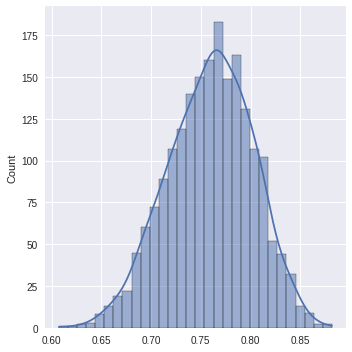

In [31]:
# mcmcでの推定パラメータを取得「
mcmc_samples = mcmc.get_samples()
print(mcmc_samples["mu"])
# muをプロット
sns.displot(
    mcmc_samples["mu"],
    kde = True
)

結果、$μ=0.76$と推定されている<br>
観測値を使用することで、真の値を推定できているように見える